Pytorch Gan 100 epoch학습시켜 보기 "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/generator4.pth"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as datasets
from PIL import Image

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
dataroot = "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/data/celeba"

In [6]:
# Set hyperparameters
batch_size = 128
image_size = 64
nz = 100 # latent vector size
ngf = 64 # generator feature map size
ndf = 64 # discriminator feature map size

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


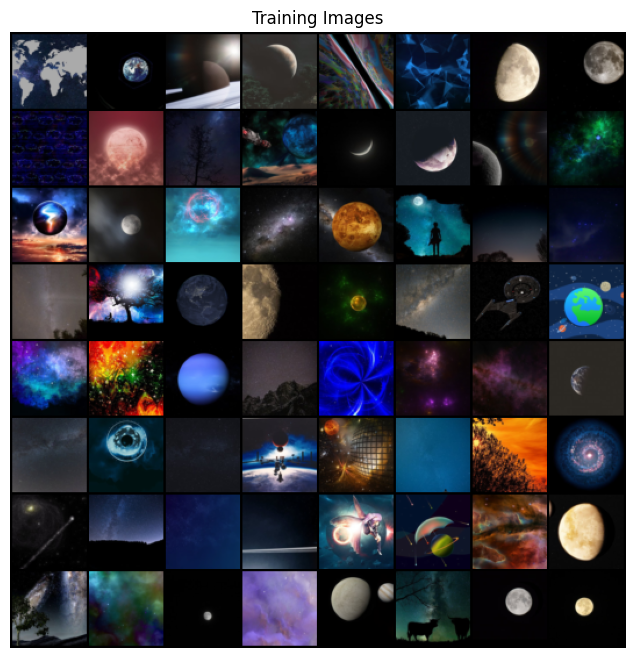

In [7]:
# 학습 데이터들 중 몇가지 이미지들을 화면에 띄우기

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [8]:
# Define generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      nn.ConvTranspose2d(nz, ngf * 8, 4, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),

      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
      nn.Tanh()
    )
  def forward(self, input):
    return self.main(input)

In [9]:
# Define discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),

       nn.Conv2d(ndf * 8, 1, kernel_size=4),
      nn.Sigmoid()
    )

  def forward(self, input):
        return self.main(input).view(-1)

In [10]:
def weights_init(m):
   # 층의 종류 추출
   classname = m.__class__.__name__
   if classname.find('Conv') != -1:
       # 합성곱층 초기화
       nn.init.normal_(m.weight.data, 0.0, 0.02)
   elif classname.find('BatchNorm') != -1:
       # 배치정규화층 초기화
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)

In [11]:
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
# Model training
num_epochs = 100
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      # Discriminator training
      netD.zero_grad()
      real = data[0].to(device)
      batch_size = real.size(0)
      # 실제 이미지에는 1, 생성된 이미지는 0으로 정답을 설정
      label = torch.ones_like(
          data[1], dtype=torch.float32).to(device)
      label_fake = torch.zeros_like(
          data[1], dtype=torch.float32).to(device)

      output = netD(real)  # output 크기는 (batch_size)
      errD_real = criterion(output, label)  # label 크기는 (batch_size)

      #errD_real = criterion(torch.squeeze(output), label)
      errD_real.backward()

      noise = torch.randn(batch_size, nz, 1, 1, device=device)
      fake = netG(noise)
      label.fill_(0)
      output = netD(fake.detach())
      errD_fake = criterion(torch.squeeze(output), label_fake)
      errD_fake.backward()

      errD = errD_real + errD_fake
      optimizerD.step()

      # Generator training
      netG.zero_grad()
      label.fill_(1)
      output = netD(fake)
      errG = criterion(torch.squeeze(output), label)
      errG.backward()
      optimizerG.step()

      if i % 100 == 0:
        print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')

[0/100][0/29] Loss_D: 1.8076 Loss_G: 6.5469
[1/100][0/29] Loss_D: 0.0564 Loss_G: 6.1771
[2/100][0/29] Loss_D: 0.2154 Loss_G: 14.5058
[3/100][0/29] Loss_D: 0.0702 Loss_G: 9.2882
[4/100][0/29] Loss_D: 0.0337 Loss_G: 6.1370
[5/100][0/29] Loss_D: 1.1572 Loss_G: 14.7723
[6/100][0/29] Loss_D: 0.6323 Loss_G: 2.1692
[7/100][0/29] Loss_D: 0.1475 Loss_G: 5.4719
[8/100][0/29] Loss_D: 0.1743 Loss_G: 6.1738
[9/100][0/29] Loss_D: 0.0476 Loss_G: 7.1466
[10/100][0/29] Loss_D: 0.1823 Loss_G: 5.1081
[11/100][0/29] Loss_D: 0.1339 Loss_G: 4.4549
[12/100][0/29] Loss_D: 0.1351 Loss_G: 3.5891
[13/100][0/29] Loss_D: 0.5149 Loss_G: 7.2767
[14/100][0/29] Loss_D: 0.4550 Loss_G: 3.5129
[15/100][0/29] Loss_D: 0.5574 Loss_G: 2.0899
[16/100][0/29] Loss_D: 0.3673 Loss_G: 3.2135
[17/100][0/29] Loss_D: 1.0196 Loss_G: 4.4867
[18/100][0/29] Loss_D: 0.2600 Loss_G: 5.1120
[19/100][0/29] Loss_D: 0.4651 Loss_G: 3.9422
[20/100][0/29] Loss_D: 0.3905 Loss_G: 3.0196
[21/100][0/29] Loss_D: 0.2133 Loss_G: 3.4139
[22/100][0/29] Los

In [14]:
# 모델 가중치 저장
torch.save(netG.state_dict(), "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/generator4.pth")
torch.save(netD.state_dict(), "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/discriminator4.pth")

# 전체 모델 저장
torch.save(netG, "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/generator_model4.pth")
torch.save(netD, "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/discriminator_model4.pth")

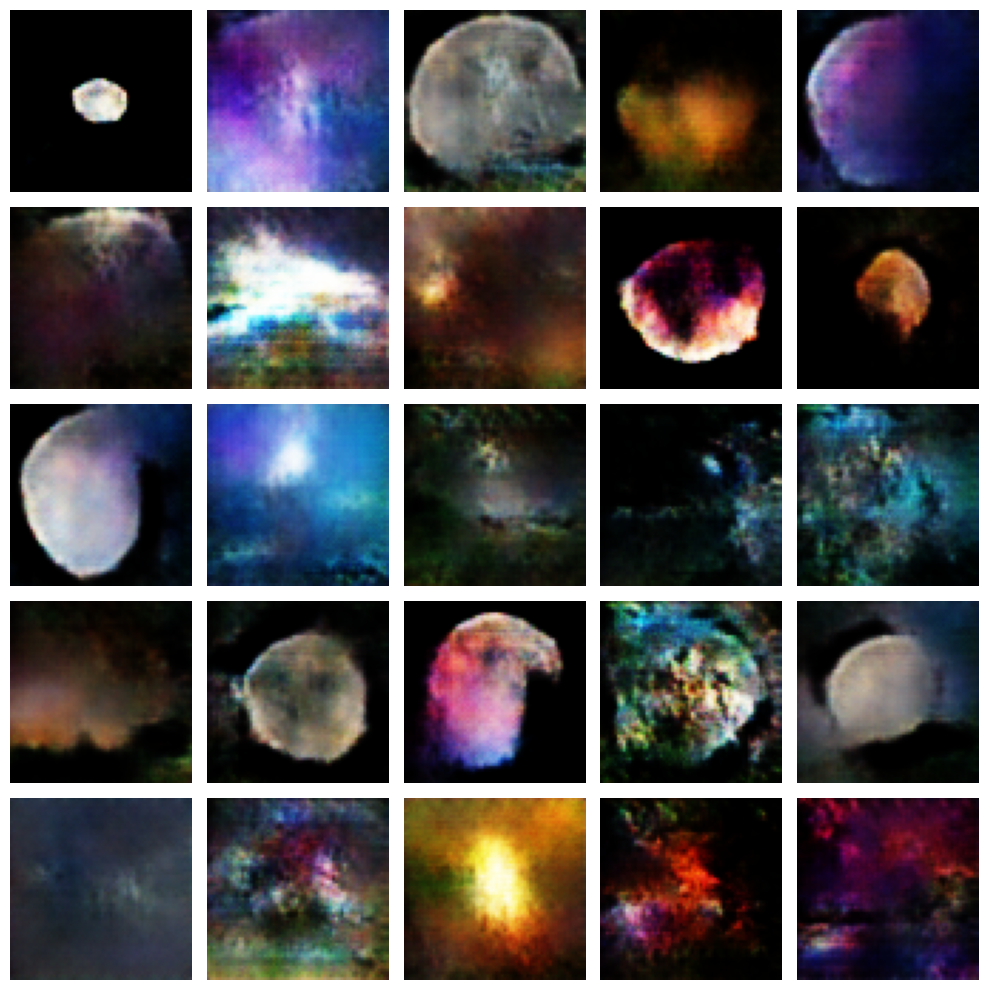

In [15]:
# Visualization
def generate_and_visualize(netG, num_images=25, nz=100, device=None):
    # If no device is provided, use CUDA if available, otherwise use CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Sample latent vector
    noise = torch.randn(num_images, nz, 1, 1, device=device)

    # Image generation
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()

    # Unnormalize
    fake_images = fake_images * 0.5 + 0.5

    # Plot images
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = fake_images[i].permute(1, 2, 0).numpy()  # Correct image shape to (H, W, C)
            ax.imshow(img)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Generate and visualize images
generate_and_visualize(netG)

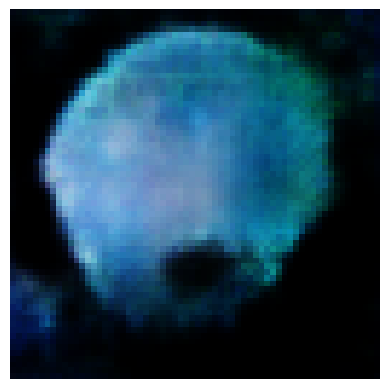

In [16]:
# 모델 로드
netG = Generator().to(device)
netG.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test4/generator4.pth"))
netG.eval()  # 평가 모드로 전환

# 랜덤 노이즈 생성
batch_size = 1  # 하나의 이미지를 생성
nz = 100  # 노이즈 벡터의 크기, 학습 시 사용한 것과 동일하게 설정
noise = torch.randn(batch_size, nz, 1, 1, device=device)

# 이미지 생성
with torch.no_grad():  # 평가 시에는 역전파 불필요
    fake_image = netG(noise).detach().cpu()  # 이미지를 생성하고 CPU로 이동

# 이미지 출력
fake_image = fake_image.squeeze(0)  # 배치 차원을 제거
fake_image = (fake_image + 1) / 2  # 정규화 해제하여 [0, 1] 범위로 변환

# 텐서를 NumPy 배열로 변환
fake_image_np = fake_image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

plt.imshow(fake_image_np, cmap="gray")
plt.axis("off")
plt.show()